<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Create-the-networks" data-toc-modified-id="Create-the-networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create the networks</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Wasserstein" data-toc-modified-id="Wasserstein-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Wasserstein</a></span></li></ul></div>

In [37]:
from utils2 import *
import keras
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

## Get the data

In [115]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [117]:
x_train = x_train / 255.; x_test = x_test / 255.

In [118]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [119]:
n_train = len(x_train); n_train

60000

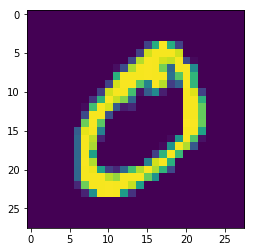

In [120]:
plt.imshow(x_train[1])

In [53]:
def create_noise(bs): return np.random.rand(bs,100)

## Create the networks

In [138]:
def create_G():
    return Sequential([
            Dense(512*7*7, input_dim=100),
            LeakyReLU(),
            BatchNormalization(),
            Reshape((7, 7, 512)),
            UpSampling2D(),
            Convolution2D(64, (3, 3), padding='same'),
            LeakyReLU(),
            BatchNormalization(),
            UpSampling2D(),
            Convolution2D(32, (3, 3), padding='same'),
            LeakyReLU(),
            BatchNormalization(),
            Convolution2D(1, (1, 1), padding='same', activation='sigmoid')
        ])

In [139]:
def create_D(final_activation='sigmoid'):
    return Sequential([
            Convolution2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
            LeakyReLU(),
            Convolution2D(512, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(),
            Flatten(),
            Dense(256),
            LeakyReLU(),
            Dense(1, activation=final_activation)
        ])

In [140]:
G = create_G()
D = create_D()

In [141]:
D.compile(Adam(1e-4), 'binary_crossentropy')

In [142]:
# Train the discriminator a little bit
sz = n_train//200
x_tmp = np.concatenate([
    np.expand_dims(np.random.permutation(x_train)[:sz], -1), 
    G.predict(create_noise(sz))
])
D.fit(x_tmp, [0]*sz + [1]*sz, batch_size=128, epochs=1)

Epoch 1/1
600/600 [==============================] - 0s - loss: 0.5591     


In [143]:
# Now create the full model
DG = Sequential([G, D])
DG.compile(Adam(1e-4), 'binary_crossentropy')

In [144]:
DG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_22 (Sequential)   (None, 28, 28, 1)         2948097   
_________________________________________________________________
sequential_23 (Sequential)   (None, 1)                 9707009   
Total params: 12,655,106
Trainable params: 12,604,738
Non-trainable params: 50,368
_________________________________________________________________


## Training

In [169]:
def get_data(size, G):
    real = np.expand_dims(x_train[np.random.randint(0, n_train, size=size)], -1)
    X = np.concatenate([real, G.predict(create_noise(size))])
    return X, [-1]*size + [1]*size

In [146]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

In [178]:
def train(D, G, DG, epochs, bs=128, clip=False):
    dl, gl = [], []
    for e in tqdm(range(epochs)):
        X, y = get_data(bs//2, G)
        if clip:
            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
        dl.append(D.train_on_batch(X, y))
        make_trainable(D, False)
        gl.append(DG.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl, gl

In [157]:
dl, gl = train(D, G, DG, 250)

100%|██████████| 250/250 [00:56<00:00,  4.45it/s]


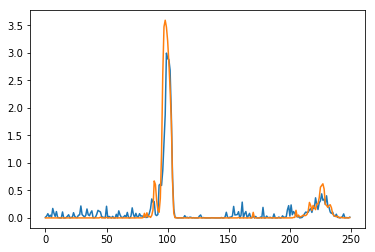

In [158]:
plt.plot(dl)
plt.plot(gl)

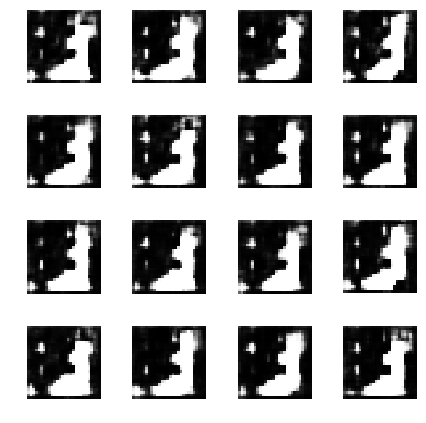

In [159]:
plot_gen(G)

## Wasserstein

In [91]:
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [179]:
D = create_D(final_activation='linear')
G = create_G()

In [180]:
D.compile(keras.optimizers.RMSprop(0.00005), d_loss)

In [181]:
DG = Sequential([G, D])
DG.compile(keras.optimizers.RMSprop(0.00005), d_loss)

In [182]:
# Train the discriminator a little bit
sz = n_train//200
x_tmp = np.concatenate([
    np.expand_dims(np.random.permutation(x_train)[:sz], -1), 
    G.predict(create_noise(sz))
])
D.fit(x_tmp, [0]*sz + [1]*sz, batch_size=128, epochs=1)

Epoch 1/1
600/600 [==============================] - 0s - loss: -1.1838     


In [183]:
dl, gl = train(D, G, DG, 250, clip=True)

100%|██████████| 250/250 [01:22<00:00,  3.03it/s]


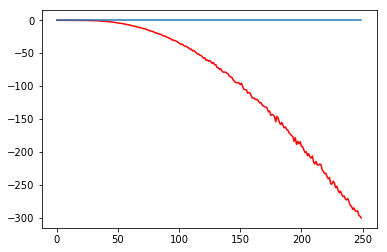

In [184]:
plt.plot(dl, c='r')
plt.plot(gl)

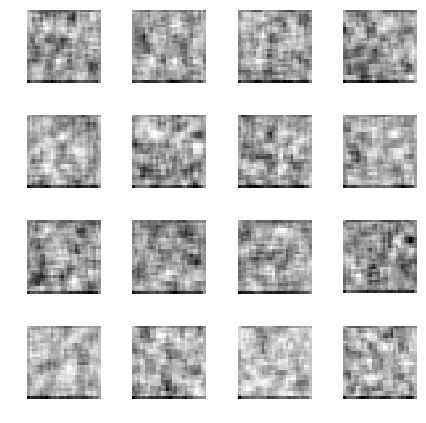

In [185]:
plot_gen(G)